In [2]:
from typing import Callable, Tuple
import numpy as np
import numpy.typing as npt

import matplotlib.pyplot as plt
from scipy.optimize import line_search

# 负梯度方法与 Newton 型方法

线搜索方法：
$$
\mathbf{x}_{k+1}=\mathbf{x}_{k}+\alpha_k\mathbf{d}_{k}
$$

In [3]:
def minimize(
    f: Callable,
    x0: npt.ArrayLike,
    grad: Callable,
    tol: float = 1e-8,
    maxiter: int = 1000
):
    x = np.zeros((maxiter+1, x0.shape[0]))  # 定义 x 初始存储空间

    x[0] = x0
    for k in range(maxiter):
        d = search_desc_direction(f, x[k], ...)  # 确定下降方向

        def phi(alpha): return f(x[k] + alpha * d)
        alpha = search_step_length(phi, ...)  # 确定最优步长

        x[k+1] = x[k] + alpha * d

        # if np.linalg.norm(g(x[k+1])) <= tol:
        # if f(x[k]) - f(x[k+1]) <= tol:
        if np.linalg.norm(x[k] - x[k+1]) <= tol:
            break

    return x[k+1], f(x[k+1])


In [4]:
def find_unimodal_interval(
    phi: Callable,
    alpha0: float,
    gamma: float = 0.1,
    t: float = 2.0,
    max_iter: int = 1000
):
    alpha_old = alpha0
    phi_alpha_old = phi(alpha_old)
    for i in range(max_iter):
        alpha = alpha_old + gamma
        phi_alpha = phi(alpha)

        if phi_alpha >= phi_alpha_old or alpha <= 0:
            if i == 0:
                gamma = -gamma
                alpha_other = alpha
            else:
                break
        else:
            gamma = t * gamma
            alpha_other = alpha_old

        alpha_old = alpha
        phi_alpha_old = phi_alpha

    return min(alpha_other, alpha), max(alpha_other, alpha)


In [ ]:
def minimize_scalar(
    phi: Callable,
    bounds=None,
    method: str = 'brent',
    tol: float = None,
    options=None
):
    pass

In [5]:
def minimize_scalar_golden(
    phi: Callable,
    bounds: Tuple[float],
    tol: float = 1e-8
):
    tau = 0.61803399
    a, b = min(bounds), max(bounds)
    h = b - a
    # Required steps to achieve tolerance
    n = int(np.ceil(np.log(tol / h) / np.log(tau)))
    a_l, a_r = a + (1 - tau) * h, a + tau * h
    phi_l, phi_r = phi(a_l), phi(a_r)
    for _ in range(n - 1):
        h = tau * h
        if phi_l < phi_r:
            b, a_r, phi_r = a_r, a_l, phi_l
            a_l = a + (1 - tau) * h
            phi_l = phi(a_l)
        else:
            a, a_l, phi_l = a_l, a_r, phi_r
            a_r = a + tau * h
            phi_r = phi(a_r)

    if phi_l < phi_r:
        alpha_star = (a + a_r) / 2
    else:
        alpha_star = (a_l + b) / 2
    return alpha_star


## 例子

In [25]:
x0 = np.array([-1.2, 1])

考虑经典的 RosenBrock 函数
$$
    f(\mathbf{x})=100\left(x_{2}-x_{1}^{2}\right)^{2}+(1-x_{1})^{2}
$$
其梯度方向为
$$
    \mathbf{g}(\mathbf{x})=\left(\begin{array}{c}
    400 x_{1}^{3}-400 x_{1}x_{2}+2 x-2 \\
    200\left(x_{2}-x_{1}^{2}\right)
    \end{array}\right)
$$
Hessian 矩阵为
$$
\mathbf{G}(\mathbf{x})= \left(\begin{array}{cc}
    1200x_{1}^{2}-400x_{1}+2 & -400x_{1}\\
    -400x_{1} & 200 \\
    \end{array}\right)
$$

In [26]:
def rosenbrock(x):
    return 100 * (x[1] - x[0]**2) ** 2 + (1 - x[0]) ** 2


def rosenbrock_grad(x):
    return np.array([400 * x[0] ** 3 - 400 * x[0] * x[1] + 2 * x[0] - 2, 200 * (x[1] - x[0]**2)])


def rosenbrock_hess(x):
    return np.array([
        [1200 * x[0] ** 2 - 400 * x[1] + 2,  -400 * x[0]], [-400*x[0], 200]
    ])


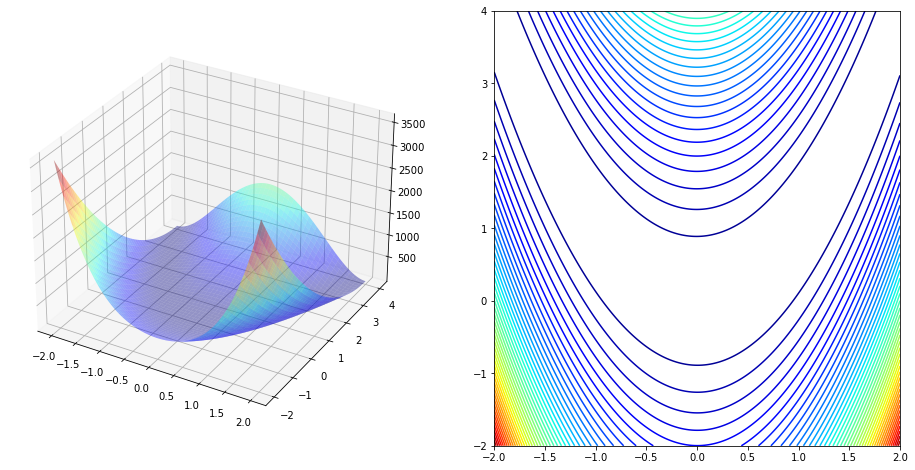

In [7]:
x = np.linspace(-2, 2, 250)
y = np.linspace(-2, 4, 250)
X, Y = np.meshgrid(x, y)
Z = rosenbrock([X, Y])
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.plot_surface(X, Y, Z, cmap="jet", alpha=.4, edgecolor='none')
ax = fig.add_subplot(1, 2, 2)
ax.contour(X, Y, Z, 50, cmap="jet")
plt.show()


In [8]:
def plot_trace(trace):
    x = np.linspace(-2, 2, 250)
    y = np.linspace(-2, 4, 250)
    X, Y = np.meshgrid(x, y)
    Z = rosenbrock([X, Y])
    trace, y_trace = trace[:, 0],  trace[:, 1]
    z_trace = rosenbrock((trace, y_trace))
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 2, 1, projection="3d")
    ax.plot_surface(X, Y, Z, cmap="jet", alpha=.4, edgecolor='none')
    ax.plot(trace, y_trace, z_trace, color='r', marker='*', alpha=.4)
    anglesx = trace[1:] - trace[:-1]
    anglesy = y_trace[1:] - y_trace[:-1]
    ax = fig.add_subplot(1, 2, 2)
    ax.contour(X, Y, Z, 50, cmap="jet")
    ax.scatter(trace, y_trace, color='r', marker='*')
    ax.quiver(trace[:-1], y_trace[:-1], anglesx, anglesy,
              scale_units='xy', angles='xy', scale=1, color='r', alpha=.3)
    plt.show()


## 负梯度方法

$$
\mathbf{d}_{k}=-\mathbf{g}_{k}
$$

### 最速下降方法（Steepest Descent, SD）



$$
\alpha_{k}=\arg\min_{\alpha}\,f(\mathbf{x}_{k}+\alpha\mathbf{d}_{k})
$$

In [38]:
def minimize_steepest(
    f: Callable,
    x0: npt.ArrayLike,
    grad: Callable,
    tol: float = 1e-8,
    maxiter: int = 1000
):
    x, fval = x0, f(x0)
    trace = np.empty((maxiter+1, len(x0)))
    trace[0] = x
    for k in range(maxiter):
        d = - grad(x)
        def phi(alpha): return f(x + alpha * d)
        # bounds = find_unimodal_interval(phi, 0)
        # alpha = minimize_scalar_golden(phi, bounds)
        alpha, _, _, _, _, _ = line_search(f, grad, x, d)
        alpha = 1 if alpha is None else alpha
        x = x + alpha * d
        trace[k+1] = x
        fval_ = f(x)
        if fval - fval_ < tol:
            break
        fval = fval_
    return x, fval_, trace[:k+1, :]

Optimal Point: (0.9900, 0.9799), Optimal Value 0.0001


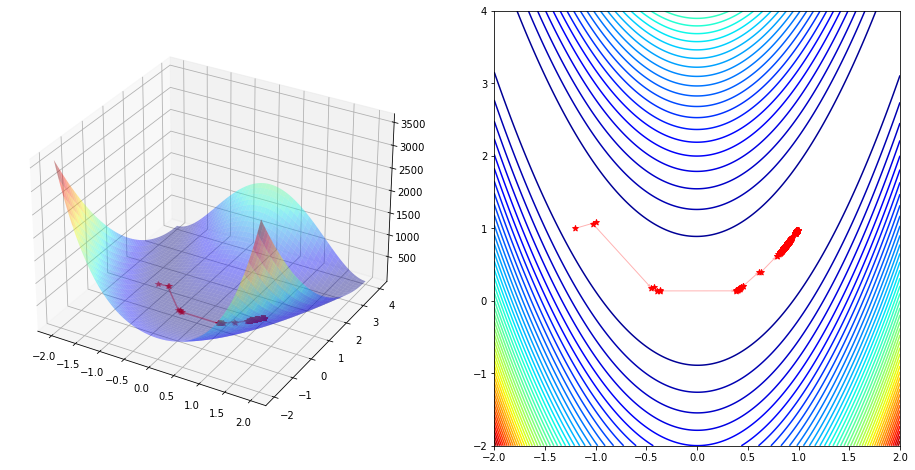

In [39]:
x, fval, trace = minimize_steepest(rosenbrock, x0, rosenbrock_grad)
print("Optimal Point: (%.4f, %.4f), Optimal Value %.4f" % (x[0], x[1], fval))
plot_trace(trace)

Optimal Point: (0.9979, 0.9958), Optimal Value 0.0000


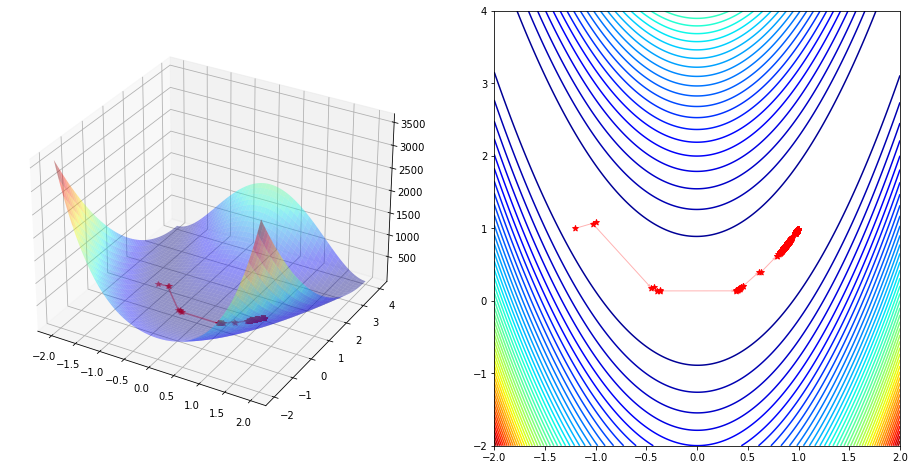

In [40]:
x, fval, trace = minimize_steepest(rosenbrock, x0, rosenbrock_grad, maxiter=10000)
print("Optimal Point: (%.4f, %.4f), Optimal Value %.4f" % (x[0], x[1], fval))
plot_trace(trace)

In [41]:
%%time
x, fval, trace = minimize_steepest(rosenbrock, x0, rosenbrock_grad)

Wall time: 270 ms


### 最小梯度方法（Minimal Gradient, MG）

$$
\alpha_{k}=\arg\min_{\alpha}\|\mathbf{g}(\mathbf{x}_{k}-\alpha\mathbf{g}_{k})\|_{2}^{2}
$$

In [42]:
def minimize_mg(
    f: Callable,
    x0: npt.ArrayLike,
    grad: Callable,
    tol: float = 1e-8,
    maxiter: int = 1000
):
    x, fval = x0, f(x0)
    trace = np.empty((maxiter+1, len(x0)))
    trace[0] = x
    for k in range(maxiter):
        d = - grad(x)
        def phi(alpha): return np.linalg.norm(grad(x + alpha * d), 2)
        # bounds = find_unimodal_interval(phi, 0.01)
        # alpha = minimize_scalar_golden(phi, bounds)
        alpha, _, _, _, _, _ = line_search(f, grad, x, d)
        alpha = 1 if alpha is None else alpha
        x = x + alpha * d
        trace[k+1] = x
        fval_ = f(x)
        if fval - fval_ < tol:
            break
        fval = fval_
    return x, fval_, trace[:k+1, :]

Optimal Point: (0.9900, 0.9799), Optimal Value 0.0001


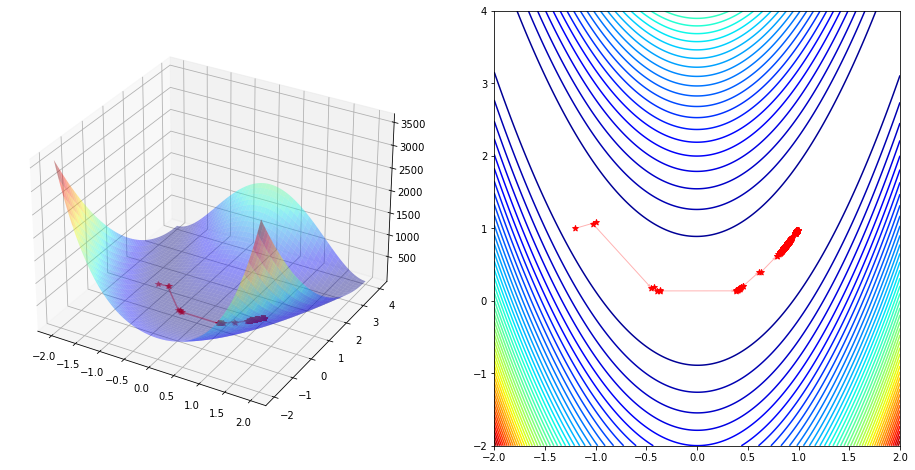

In [43]:
x, fval, trace = minimize_mg(rosenbrock, x0, rosenbrock_grad)
print("Optimal Point: (%.4f, %.4f), Optimal Value %.4f" % (x[0], x[1], fval))
plot_trace(trace)

### BB 方法（Barzilai & Borwein, BB）

给定
$$
\begin{aligned}
&\mathbf{s}_{k}=\mathbf{x}_{k+1}-\mathbf{x}_{k} \\
&\mathbf{y}_{k}=\mathbf{g}_{k+1}-\mathbf{g}_{k}
\end{aligned}
$$

$$
\alpha_{k}=\arg\min_{\alpha}\|\alpha^{-1}\mathbf{s}_{k-1}-\mathbf{y}_{k-1}\|_{2}^{2}
$$
或
$$
\alpha_{k}=\arg\min_{\alpha}\|\mathbf{s}_{k-1}-\alpha\mathbf{y}_{k-1}\|_{2}^{2}
$$

解得
$$
\alpha_{k}=\frac{\mathbf{s}_{k-1}^{\prime}\mathbf{s}_{k-1}}{\mathbf{s}_{k-1}^{\prime}\mathbf{y}_{k-1}}
$$
或
$$
\alpha_{k}=\frac{\mathbf{y}_{k-1}^{\prime}\mathbf{s}_{k-1}}{\mathbf{y}_{k-1}^{\prime}\mathbf{y}_{k-1}}
$$

In [99]:
def minimize_bb(
    f: Callable,
    x0: npt.ArrayLike,
    grad: Callable,
    method: str = "BB1",
    tol: float = 1e-8,
    maxiter: int = 10000,
):
    x, fval = x0, f(x0)
    g = grad(x)
    trace = np.empty((maxiter+1, len(x0)))
    trace[0] = x

    for k in range(maxiter):
        d = - g
        if k == 0:
            def phi(alpha): return f(x + alpha * d)
            # bounds = find_unimodal_interval(phi, 0)
            # alpha = minimize_scalar_golden(phi, bounds)
            alpha, _, _, _, _, _ = line_search(f, grad, x, d)
            alpha = 1 if alpha is None else alpha
        elif method == "BB1":
            alpha = (s.T @ s) / (s.T @ y)
            alpha = alpha.item()
            alpha = 1 if alpha <= 1e-10 or alpha > 1e10 else alpha
        elif method == "BB2":
            alpha = (y.T @ s) / (y.T @ y)
            alpha = alpha.item()
            alpha = 1 if alpha <= 1e-10 or alpha > 1e10 else alpha
        x_new = x + alpha * d

        g_new = grad(x_new)
        s, y = x_new - x, g_new - g
        s, y = s[:, np.newaxis], y[:, np.newaxis]
        x, g = x_new, g_new
        trace[k+1] = x
        fval_ = f(x)
        if np.linalg.norm(g) <= tol:
        # if fval - fval_ <= tol:
            break
        fval = fval_
    return x, fval_, trace[:k+1, :]

Optimal Point: (0.0355, 0.0003), Optimal Value 0.9304


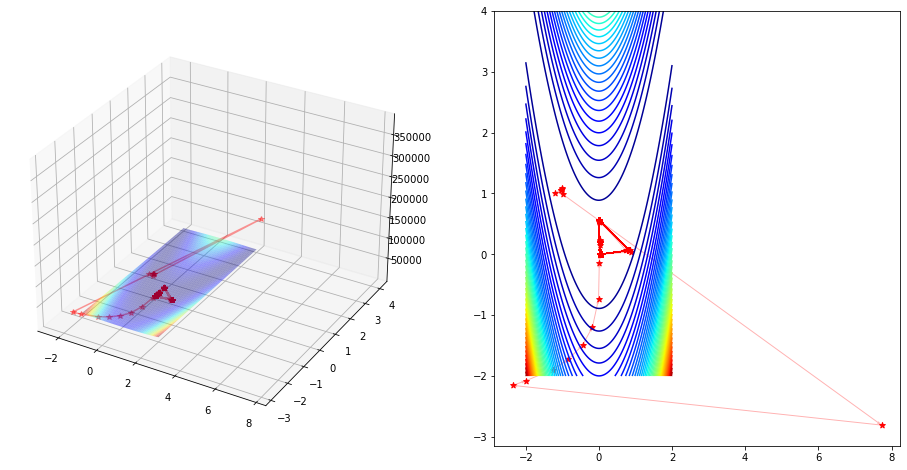

In [100]:
x, fval, trace = minimize_bb(rosenbrock, x0, rosenbrock_grad, method="BB1")
print("Optimal Point: (%.4f, %.4f), Optimal Value %.4f" % (x[0], x[1], fval))
plot_trace(trace)

## 牛顿方法

$$
\mathbf{G}_{k}\mathbf{d}_{k}=-\mathbf{g}_{k}
$$

### 基本 Newton 方法

$$
\alpha_{k}=1
$$

In [14]:
def minimize_newton(
    f: Callable,
    x0: npt.ArrayLike,
    grad: Callable,
    hess: Callable,
    tol: float = 1e-8,
    maxiter: int = 1000,
):
    x, fval = x0, f(x0)
    trace = np.empty((maxiter+1, len(x0)))
    trace[0] = x
    for k in range(maxiter):
        H = hess(x)
        d = - grad(x) @ np.linalg.inv(H).T
        x = x + d
        trace[k+1] = x
        fval_ = f(x)
        if fval - fval_ < tol:
        # if np.linalg.norm(grad(x)) <= tol:
            break
        fval = fval_
    return x, fval_, trace[:k+1, :]

Optimal Point: (0.7631, -3.1750), Optimal Value 1411.8452


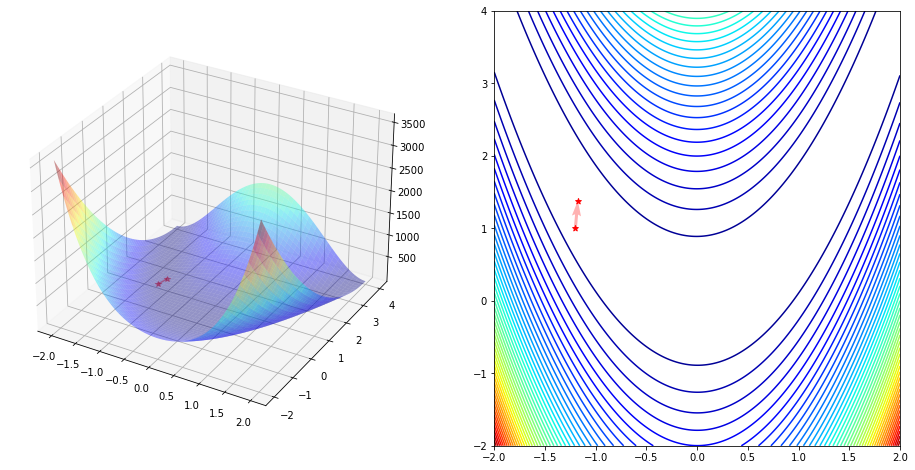

In [15]:
x, fval, trace = minimize_newton(rosenbrock, x0, rosenbrock_grad, rosenbrock_hess)
print("Optimal Point: (%.4f, %.4f), Optimal Value %.4f" % (x[0], x[1], fval))
plot_trace(trace)

### 混合 Newton 方法

### 阻尼 Newton 方法

$$
\alpha_{k}=\arg\min_{\alpha}\,f(\mathbf{x}_{k}+\alpha\mathbf{d}_{k})
$$

In [16]:
def minimize_newton_damp(
    f: Callable,
    x0: npt.ArrayLike,
    grad: Callable,
    hess: Callable,
    tol: float = 1e-8,
    maxiter: int = 1000,
):
    x, fval = x0, f(x0)
    trace = np.empty((maxiter+1, len(x0)))
    trace[0] = x
    for k in range(maxiter):
        H = hess(x)
        d = - grad(x) @ np.linalg.inv(H).T
        def phi(alpha): return f(x + alpha * d)
        bounds = find_unimodal_interval(phi, 0)
        alpha = minimize_scalar_golden(phi, bounds)
        x = x + alpha * d
        trace[k+1] = x
        fval_ = f(x)
        if fval - fval_ < tol:
            break
        fval = fval_
    return x, fval_, trace[:k+1, :]

Optimal Point: (1.0000, 1.0000), Optimal Value 0.0000


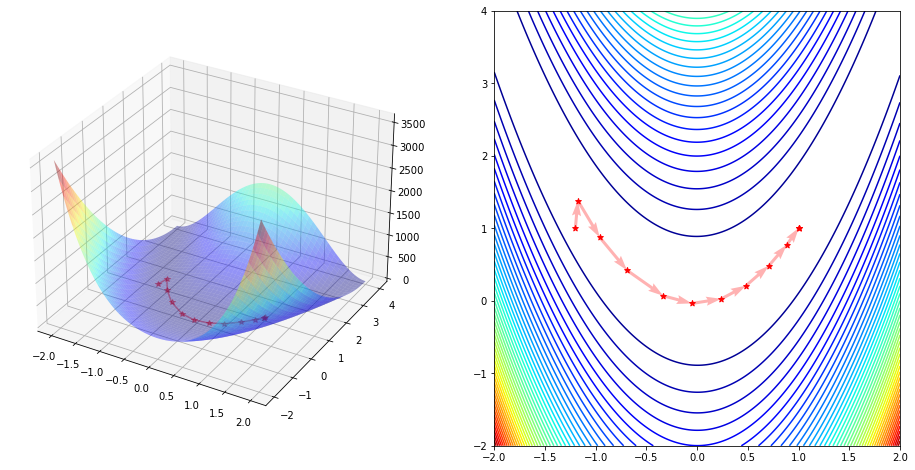

In [17]:
x, fval, trace = minimize_newton_damp(rosenbrock, x0, rosenbrock_grad, rosenbrock_hess)
print("Optimal Point: (%.4f, %.4f), Optimal Value %.4f" % (x[0], x[1], fval))
plot_trace(trace)

### LM 方法

$$
(\mathbf{G}_{k}+\nu_{k}\mathbf{I})\mathbf{d}_{k}=-\mathbf{g}_{k}
$$

In [18]:
def minimize_newton_lm(
    f: Callable,
    x0: npt.ArrayLike,
    grad: Callable,
    hess: Callable,
    nu: float = 0.01,
    tol: float = 1e-8,
    maxiter: int = 1000,
):
    x, fval = x0, f(x0)
    trace = np.empty((maxiter+1, len(x0)))
    trace[0] = x
    for k in range(maxiter):
        H = hess(x)
        d = - grad(x) @ np.linalg.inv(H + nu * np.eye(len(x0))).T
        nu = 2 * nu
        x = x + d
        trace[k+1] = x
        fval_ = f(x)
        if fval - fval_ < tol:
        # if np.linalg.norm(grad(x)) <= tol:
            break
        fval = fval_
    return x, fval_, trace[:k+1, :]

Optimal Point: (0.6500, -2.9086), Optimal Value 1109.7692


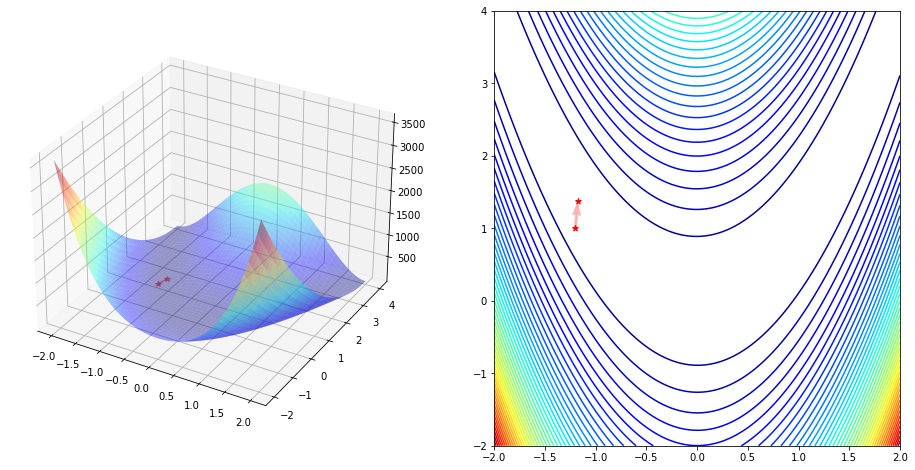

In [19]:
x, fval, trace = minimize_newton_lm(rosenbrock, x0, rosenbrock_grad, rosenbrock_hess)
print("Optimal Point: (%.4f, %.4f), Optimal Value %.4f" % (x[0], x[1], fval))
plot_trace(trace)

## 拟牛顿方法

$$
\mathbf{d}_{k}=-\mathbf{H}_{k}g_{k},\quad\alpha_{k}=\arg\min_{\alpha}\,f(\mathbf{x}_{k}+\alpha\mathbf{d}_{k})
$$

给定
$$
\begin{aligned}
&\mathbf{s}_{k}=\mathbf{x}_{k+1}-\mathbf{x}_{k} \\
&\mathbf{y}_{k}=\mathbf{g}_{k+1}-\mathbf{g}_{k}
\end{aligned}
$$

$$
H_{k+1}^{\mathrm{SR} 1}=H_{k}+\frac{\left(s_{k}-H_{k} y_{k}\right)\left(s_{k}-H_{k} y_{k}\right)^{\prime}}{\left(s_{k}-H_{k} y_{k}\right)^{\prime} y_{k}}
$$

$$
H_{k+1}^{\mathrm{DFP}}=H_{k}+\frac{s_{k} s_{k}^{\prime}}{s_{k}^{\prime} y_{k}}-\frac{H_{k} y_{k} y_{k}^{\prime} H_{k}}{y_{k}^{\prime} H_{k} y_{k}}
$$

$$
H_{k+1}^{\mathrm{BFGS}}=H_{k}+\left(1+\frac{y_{k}^{\prime} H_{k} y_{k}}{y_{k}^{\prime} s_{k}}\right) \frac{s_{k} s_{k}^{\prime}}{y_{k}^{\prime} s_{k}}-\left(\frac{s_{k} y_{k}^{\prime} H_{k}+H_{k} y_{k} s_{k}^{\prime}}{y_{k}^{\prime} s_{k}}\right)
$$

In [20]:
def minimize_quasi_newton(
    f: Callable,
    x0: npt.ArrayLike,
    grad: Callable,
    hess: str = "BFGS",
    tol: float = 1e-8,
    maxiter: int = 10000,
):
    x, fval = x0, f(x0)
    H, g = np.eye(len(x0)), grad(x)
    trace = np.empty((maxiter+1, len(x0)))
    trace[0] = x
    for k in range(maxiter):
        d = - g @ H.T
        def phi(alpha): return f(x + alpha * d)
        bounds = find_unimodal_interval(phi, 0)
        alpha = minimize_scalar_golden(phi, bounds)
        # alpha, _, _, _, _, _ = line_search(f, grad, x, d)
        # alpha = 1 if alpha is None else alpha
        x_new = x + alpha * d
        g_new = grad(x_new)
        s, y = x_new - x, g_new - g
        s, y = s[:, np.newaxis], y[:, np.newaxis]
        x, g = x_new, g_new
        trace[k+1] = x
        if hess == "SR1":
            # error
            sHy = s - H @ y
            delta_H = ((sHy) @ (sHy).T) / ((sHy).T @ y)
        elif hess == "DFP":
            delta_H = (s @ s.T) / (s.T @ y) - (H @ y @ y.T @ H) / (y.T @ H @ y)
        elif hess == "BFGS":
            delta_H = (1 + (y.T @ H @ y) / (y.T @ s)) * ((s @ s.T) / (y.T @ s)) \
                - ((s @ y.T @ H + H @ y @ s.T) / (y.T @ s))
        H = H + delta_H
        fval_ = f(x)
        # if np.linalg.norm(g) <= tol:
        if fval - fval_ <= tol:
            break
        fval = fval_
    return x, fval_, trace[:k+1, :]

In [21]:
def minimize_quasi_newton(
    f: Callable,
    x0: npt.ArrayLike,
    grad: Callable,
    hess: str = "BFGS",
    tol: float = 1e-8,
    maxiter: int = 10000,
):
    x, fval = x0, f(x0)
    H, g = np.eye(len(x0)), grad(x)
    trace = np.empty((maxiter+1, len(x0)))
    trace[0] = x
    for k in range(maxiter):
        d = - g @ H.T
        def phi(alpha): return f(x + alpha * d)
        bounds = find_unimodal_interval(phi, 0)
        alpha = minimize_scalar_golden(phi, bounds)
        # alpha, _, _, _, _, _ = line_search(f, grad, x, d)
        # alpha = 1 if alpha is None else alpha
        x_new = x + alpha * d
        g_new = grad(x_new)
        s, y = x_new - x, g_new - g
        s, y = s[:, np.newaxis], y[:, np.newaxis]
        x, g = x_new, g_new
        trace[k+1] = x
        if hess == "SR1":
            # error
            sHy = s - H @ y
            delta_H = ((sHy) @ (sHy).T) / ((sHy).T @ y)
        elif hess == "DFP":
            delta_H = (s @ s.T) / (s.T @ y) - (H @ y @ y.T @ H) / (y.T @ H @ y)
        elif hess == "BFGS":
            delta_H = (1 + (y.T @ H @ y) / (y.T @ s)) * ((s @ s.T) / (y.T @ s)) \
                - ((s @ y.T @ H + H @ y @ s.T) / (y.T @ s))
        H = H + delta_H
        fval_ = f(x)
        # if np.linalg.norm(g) <= tol:
        if fval - fval_ <= tol:
            break
        fval = fval_
    return x, fval_, trace[:k+1, :]

Optimal Point: (1.2211, 1.4743), Optimal Value 0.0766


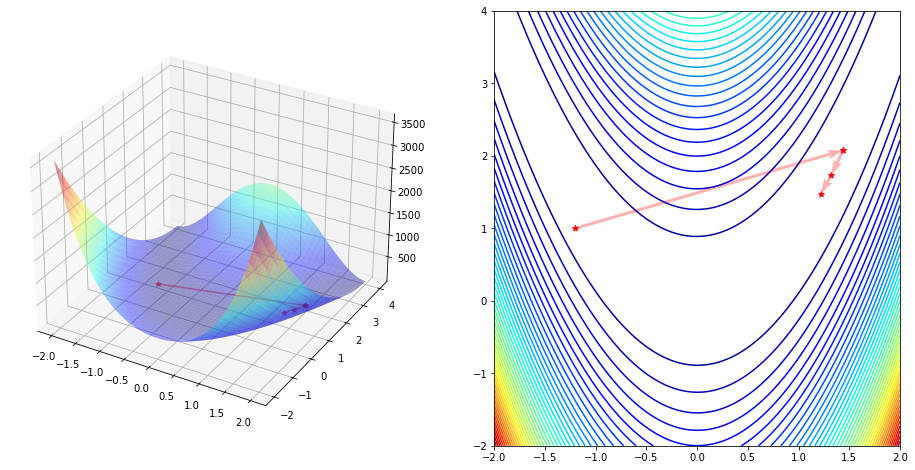

In [22]:
x, fval, trace = minimize_quasi_newton(rosenbrock, x0, rosenbrock_grad, hess="SR1")
print("Optimal Point: (%.4f, %.4f), Optimal Value %.4f" % (x[0], x[1], fval))
plot_trace(trace)

Optimal Point: (1.0000, 1.0000), Optimal Value 0.0000


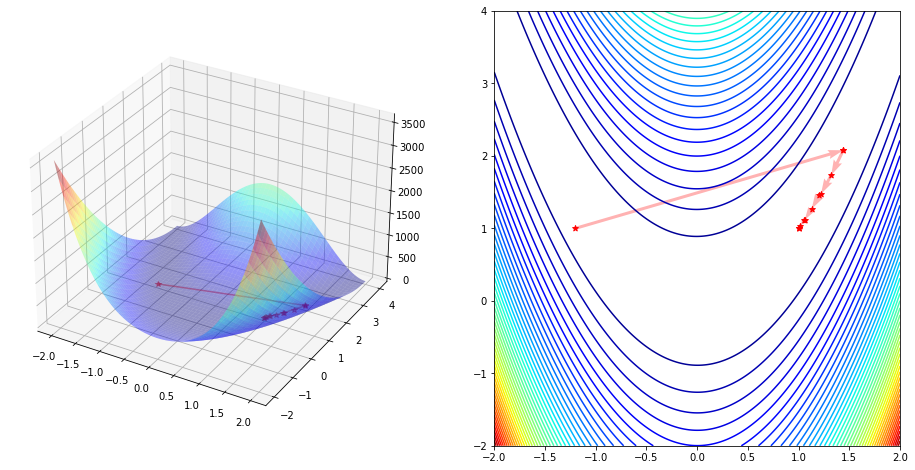

In [23]:
x, fval, trace = minimize_quasi_newton(rosenbrock, x0, rosenbrock_grad, hess="DFP")
print("Optimal Point: (%.4f, %.4f), Optimal Value %.4f" % (x[0], x[1], fval))
plot_trace(trace)

Optimal Point: (1.0000, 1.0000), Optimal Value 0.0000


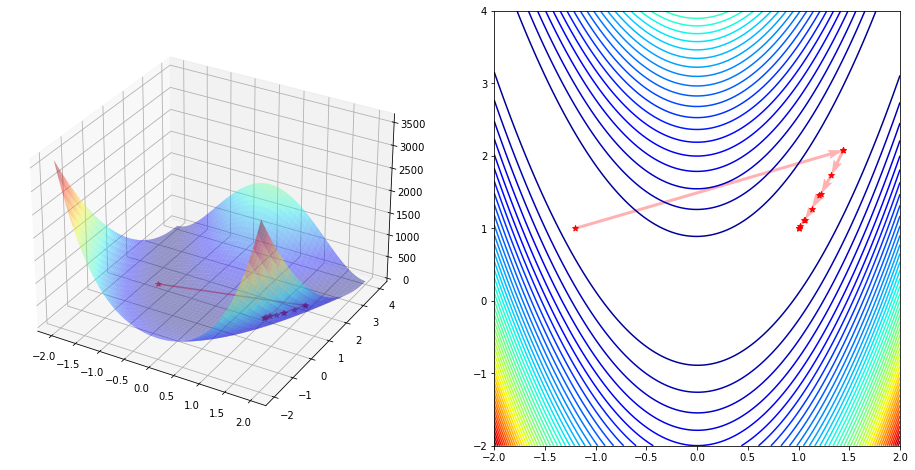

In [24]:
x, fval, trace = minimize_quasi_newton(rosenbrock, x0, rosenbrock_grad, hess="BFGS")
print("Optimal Point: (%.4f, %.4f), Optimal Value %.4f" % (x[0], x[1], fval))
plot_trace(trace)